In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

## Load training and test data

In [2]:
train_df=pd.read_csv('../input/toxic-comment/train.csv')
test_df=pd.read_csv('../input/toxic-comment/test.csv')

## Examine the data(EDA)

In [3]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
11278,1ddb42db446cae9e,What are you talking about? This was opened a...,0,0,0,0,0,0
131237,be3eb88070081054,"""\n\nDiphenhydramine edit\n\nWhy was my edit i...",0,0,0,0,0,0
50960,884d1336bbe11332,Done but it seems like Deepcruze's other edits...,0,0,0,0,0,0
101448,1ef85adb9ae621f5,"27 22:41, 26 Sep 2004 (UTC)",0,0,0,0,0,0
22336,3ae99b94e44b0b1a,"""::In fact Aram meant nothing more than highla...",0,0,0,0,0,0


In [4]:
cols_target=['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [5]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
unlabelled_in_all=train_df[(train_df['toxic']!=1)&(train_df['severe_toxic']!=1)&(train_df['obscene']!=1)&(train_df['threat']!=1)&(train_df['insult']!=1)&(train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ',len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


In [7]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
no_comment=test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


In [9]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [10]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length']=train_df['comment_text'].apply(lambda x:len(str(x)))

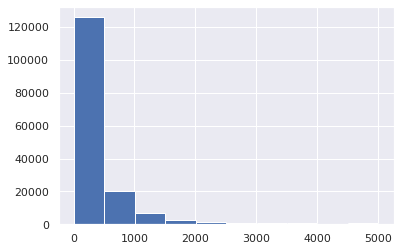

In [11]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

In [12]:
data=train_df[cols_target]

<AxesSubplot:title={'center':'Correlation of features & targets'}>

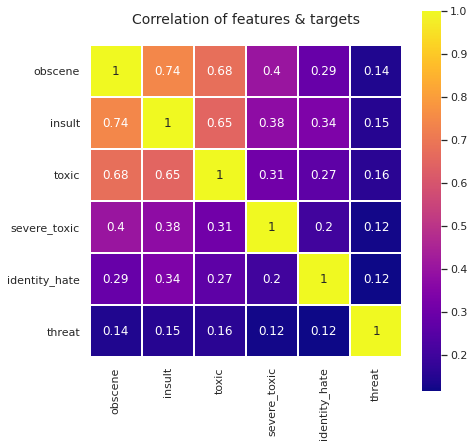

In [13]:
colormap=plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True,cmap=colormap, linecolor='white',annot=True)

In [14]:
test_df['char_length']=test_df['comment_text'].apply(lambda x:len(str(x)))

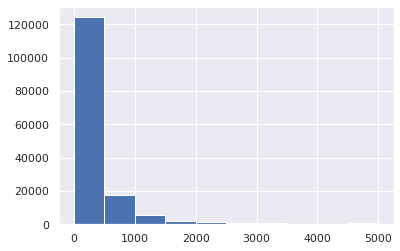

In [15]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

## Clean up the comment text

In [16]:
def clean_text(text):
    text=text.lower()
    text=re.sub(r"what's","what is ",text)
    text=re.sub(r"\'s'"," ",text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [17]:
# clean the comment_text in train_df[Thanks to Pulkit Jha for the useful pointer]
train_df['comment_text'] = train_df['comment_text'].map(lambda com:clean_text(com))

In [18]:
# clean the comment_text in test_df[Thanks, Pulkit Jha]
test_df['comment_text']=test_df['comment_text'].map(lambda com:clean_text(com))

## Define X from entire train & test data for use in tokenization by Vectorizer

In [19]:
train_df=train_df.drop('char_length',axis=1)

In [20]:
X=train_df.comment_text
test_X=test_df.comment_text

In [21]:
print(X.shape,test_X.shape)

(159571,) (153164,)


## Vectorize the data

In [22]:
# import and instantiate TfidVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000, stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [23]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm=vect.fit_transform(X)

# examine the document-term matrix created from X_train
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178963 stored elements in Compressed Sparse Row format>

In [24]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)

# examine the document-term matrix from X_test
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2619155 stored elements in Compressed Sparse Row format>

## Solving a multi-label classification problem

- Binary Relevance. This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.
- Classifier Chains. In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.
- Label Powerset. This method transforms the problem into a multi-class problem where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^6 or 64-class problem. {Thanks Joshua for pointing out.}

## Binary Relevance- build a multi-label classifier using Logistic Regression

In [26]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg=LogisticRegression(C=12.0,solver='liblinear')

# create submission file
submission_binary=pd.read_csv('../input/toxic-comment/sample_submission.csv')

for label in cols_target:
    print('... Processing {}'.format(label))
    y=train_df[label]
    
    # train the model using X_dtm & y
    logreg.fit(X_dtm,y)
    
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    
    print('Training accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    
    # compute the predicted probabilities for X_test_dtm
    test_y_prob=logreg.predict_log_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

... Processing obscene
Training accuracy is 0.9832049683213115
... Processing insult
Training accuracy is 0.9755281348114633
... Processing toxic
Training accuracy is 0.9639596167223368
... Processing severe_toxic
Training accuracy is 0.9920912947841399
... Processing identity_hate
Training accuracy is 0.9939713356436947
... Processing threat
Training accuracy is 0.9981199591404453


## Create submission file

In [27]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-0.000043,-0.770425,-0.000035,-2.987599,-0.029288,-0.842058
1,0000247867823ef7,-6.038451,-7.752632,-7.830782,-8.019731,-5.721685,-7.843986
2,00013b17ad220c46,-4.526182,-9.036744,-5.684547,-10.252449,-4.931026,-6.685352
3,00017563c3f7919a,-6.635006,-6.134836,-6.945568,-9.053035,-7.048179,-10.310026
4,00017695ad8997eb,-3.949882,-7.092655,-6.687563,-7.412607,-5.720289,-7.483864


In [28]:
# generate submission file
submission_binary.to_csv('submission_binary.csv',index=False)

### Binary Relevance with Logistic Regression classifier scored 0.074 on the public leaderboard

## Classifier Chains - build a multi-label classifier using Logistic Regression

In [29]:
# create submission file
submission_chains=pd.read_csv('../input/toxic-comment/sample_submission.csv')

# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns spars feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    
    from scipy.sparse import csr_matrix, hstack
    return hstack([X,csr_matrix(feature_to_add).T],'csr')

In [30]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm,y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    # make predictions from test_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

... Processing obscene
Training Accuracy is 0.9832049683213115
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing insult
Training Accuracy is 0.9818889397196232
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing toxic
Training Accuracy is 0.9676507636099291
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing severe_toxic
Training Accuracy is 0.9931065168482995
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing identity_hate
Training Accuracy is 0.9955693703743161
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing threat
Training Accuracy is 0.9985774357496037
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


## Create submission file

In [31]:
submission_chains.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999968,0.419262,0.999965,0.189607,0.900254,0.600033
1,0000247867823ef7,0.002526,0.000003,0.000397,0.000077,0.004431,0.000120
2,00013b17ad220c46,0.007654,0.000001,0.003398,0.000010,0.004986,0.000525
3,00017563c3f7919a,0.001169,0.000070,0.000963,0.000069,0.000640,0.000006
4,00017695ad8997eb,0.021106,0.000006,0.001246,0.000171,0.002029,0.000106


In [32]:
# generate submission file
submission_chains.to_csv('submission_chains.csv',index=False)

## Create a combined submission

In [33]:
# create submission file
submission_combined=pd.read_csv('../input/toxic-comment/sample_submission.csv')

Combine using simple average from Binary Relevance and Classifier Chains.

In [34]:
# corr_tragets = ['obscene','insult','toxic']
for label in cols_target:
    submission_combined[label]=0.5*(submission_chains[label]+submission_binary[label])

In [35]:
submission_combined.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.499963,-0.175581,0.499965,-1.398996,0.435483,-0.121013
1,0000247867823ef7,-3.017962,-3.876315,-3.915192,-4.009827,-2.858627,-3.921933
2,00013b17ad220c46,-2.259264,-4.518372,-2.840574,-5.126219,-2.463020,-3.342413
3,00017563c3f7919a,-3.316918,-3.067383,-3.472303,-4.526483,-3.523770,-5.155010
4,00017695ad8997eb,-1.964388,-3.546325,-3.343159,-3.706218,-2.859130,-3.741879


In [36]:
# generate submission file
submission_combined.to_csv('submission_combined.csv',index=False)

https://www.kaggle.com/rhodiumbeng/classifying-multi-label-comments-0-9741-lb